In [2]:
import sys
import os
import json
import glob

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/2025_data"))
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger"))
sys.path.append('/eos/home-d/dcostasr/SWAN_projects/software/hipy')

import hipy.pltext       as pltext
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np

from src.read_data import process_and_write_parts, load_concatenated
from wcte.brbtools import sort_run_files, get_part_files, select_good_parts
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

pltext.style()

In [ ]:
# ================= READS .root WITH THE RUN DATA AND WRITES TO DISK PROCESSED INFORMATION ===================================
# run        = 1626
# run_files  = sort_run_files(f"/eos/experiment/wcte/data/2025_commissioning/offline_data/{run}/WCTE_offline_R{run}S*P*.root")
# part_files = get_part_files(run_files)
# good_parts = select_good_parts(part_files, run_files)

# with open('/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger/mmc_map_R1609.json') as f:
#     mcc_map = json.load(f)

# d = {}
# for k,v in zip(mcc_map.keys(), mcc_map.values()):
#     card, channel = [int(i) for i in str(int(k)/100).split(".")]
#     d[(card, channel)] = v

# mcc_map = d

# process_and_write_parts(run_files, good_parts, mcc_map, max_card=118, max_chan=19)

In [ ]:
# ============= LOADS THE DATA ===================
# data = load_concatenated(outdir="./tmp_parquet")

In [ ]:
hit_times   = data["hit_times"]
hit_charges = data["charges"]

In [67]:
len(hit_times)

3832

In [ ]:
# ============ nHITS TRIGGER ALGORITHM ITSELF ================================
# ============ FIRST VERSION: 1 TRIGGER PER READOUT WINDOW ===================

nevents = len(hit_times)
triggered_hits_index = {}

for event in tqdm(range(nevents), total=nevents):
    ht = ak.to_numpy(ak.sort(hit_times[event]))
    w = 200
    t = 20
    pre_window = 50
    post_window = 100

    # Sliding window trigger
    starts = ht
    ends   = ht + w
    right  = np.searchsorted(ht, ends, side="left")
    left   = np.arange(len(ht))
    counts = right - left

    # Detection of the first trigger
    threshold_mask = (counts > t)
    if np.any(threshold_mask):
        trigger_index = np.where(threshold_mask)[0][0]
        time_triggered = ht[trigger_index]

        # Window centered in the trigger
        t_min = time_triggered - pre_window
        t_max = time_triggered + post_window

        indices_in_window = np.where((ht >= t_min) & (ht < t_max))[0]
        hits_in_window = ht[indices_in_window]

        # print("Trigger en:", time_triggered)
        # print("Índice del trigger:", trigger_index)
        # print("Índices en la ventana centrada:", indices_in_window)
        # print("Hits en la ventana centrada:", hits_in_window)
        # print(f"Event {event} triggered")
        triggered_hits_index[event] = indices_in_window
    else:
        None
        # print(f"Event {event} did not trigger")

  0%|          | 0/3832 [00:00<?, ?it/s]

In [ ]:
# Sort by number of hits in the window
top5 = sorted(triggered_hits_index.items(), key=lambda x: len(x[1]), reverse=True)[:5]

# Print 5 windows with the bigger amount of hits
for i, (event_id, indices) in enumerate(top5, 1):
    print(f"{i}. Evento {event_id} con {len(indices)} hits")

1. Evento 243 con 126 hits
2. Evento 246 con 125 hits
3. Evento 3322 con 122 hits
4. Evento 2078 con 121 hits
5. Evento 166 con 120 hits


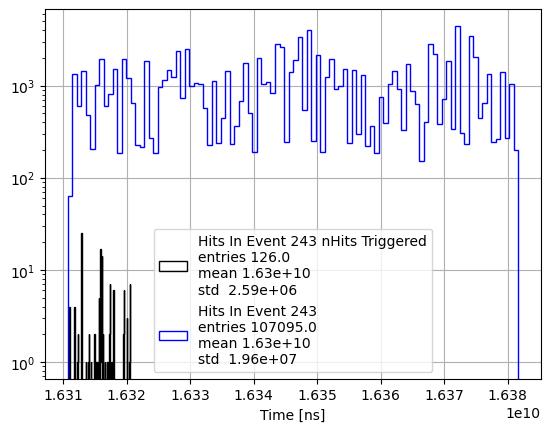

In [103]:
event = 243
pltext.hist(hit_times[event][triggered_hits_index[event]], 100, ylog=True, label=f"Hits In Event {event} nHits Triggered", formate=".2e");
pltext.hist(hit_times[event], 100, ylog=True, xylabels=("Time [ns]"), label=f"Hits In Event {event}", formate=".2e");

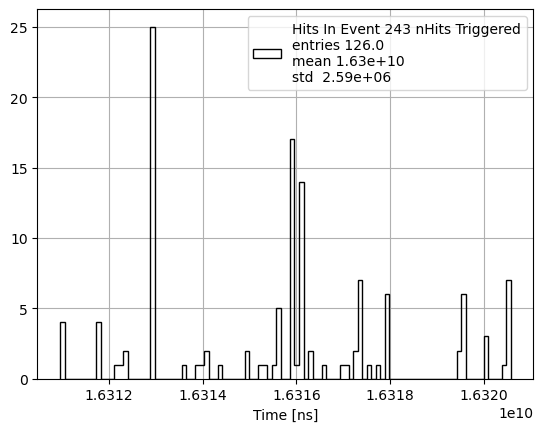

In [104]:
pltext.hist(hit_times[event][triggered_hits_index[event]], 100, ylog=False, xylabels=("Time [ns]"), label=f"Hits In Event {event} nHits Triggered", formate=".2e");

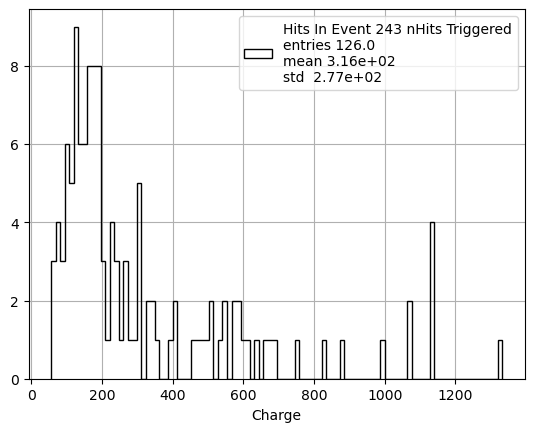

In [105]:
pltext.hist(hit_charges[event][triggered_hits_index[event]], 100, ylog=False, xylabels=("Charge"), label=f"Hits In Event {event} nHits Triggered", formate=".2e");

In [ ]:
# ============ SECOND VERSION: AS MUCH TRIGGERS PER READOUT WINDOW AS WE FIND ===================
nevents = len(hit_times)
triggered_hits_index = {}

w = 150
t = 100
pre_window  = 50
post_window = 50
jump = 2000  # Trigger dead time

# Run the algorithm for every readout window
for event in tqdm(range(nevents), total=nevents):
    ht = ak.to_numpy(ak.sort(hit_times[event]))
    if len(ht) == 0: # Skip if event empty
        continue
    
    # Count hits in window
    ends = ht + w
    right = np.searchsorted(ht, ends, side="left")
    left  = np.arange(len(ht))
    counts = right - left

    # Get the indices of all the hit times that triggered the nHits algorithm
    trigger_indices = np.where(counts > t)[0]
    if len(trigger_indices) == 0: # Skip if no triggers in event
        continue

    event_hits = []
    last_trigger_time = -np.inf  # First trigger always need to exist

    # Search for the rest of the hits in the trigger
    for idx in trigger_indices:
        time_triggered = ht[idx]

        # If we are inside the dead time, ignore this trigger
        if time_triggered < last_trigger_time + jump:
            continue

        # Window centered in the first hit that trigger the algorithm
        t_min = time_triggered - pre_window
        t_max = time_triggered + post_window
        indices_in_window = np.where((ht >= t_min) & (ht < t_max))[0]
        event_hits.append(indices_in_window) # Append hit_times of the trigger

        # Update last valid trigger time
        last_trigger_time = time_triggered

    # Update dictionary
    if len(event_hits) > 0:
        triggered_hits_index[event] = event_hits


  0%|          | 0/3832 [00:00<?, ?it/s]

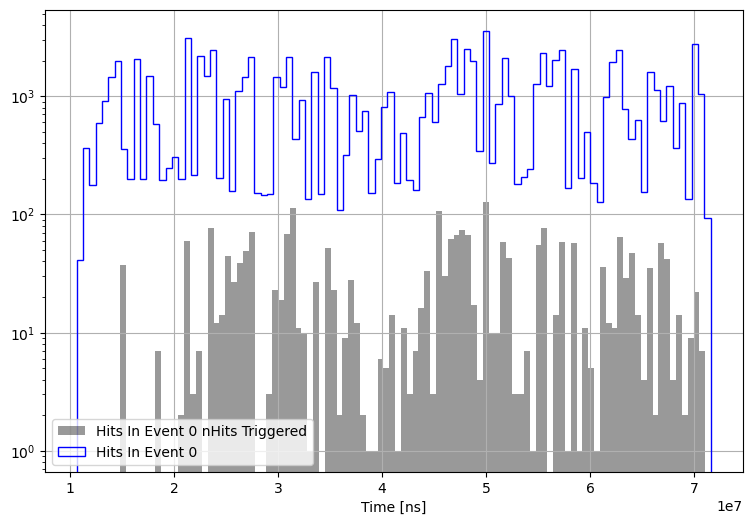

In [ ]:
# Some Plots 
event = 0
triggered_hits = np.concatenate(triggered_hits_index[event])

fig = plt.figure(figsize=(9,6))
pltext.hist(hit_times[event][triggered_hits], 100, ylog=True, 
            stats=False, label=f"Hits In Event {event} nHits Triggered", formate=".2e", 
            histtype="stepfilled", alpha=0.4);
pltext.hist(hit_times[event], 100, ylog=True, xylabels=("Time [ns]"), stats=False, label=f"Hits In Event {event}", formate=".2e");

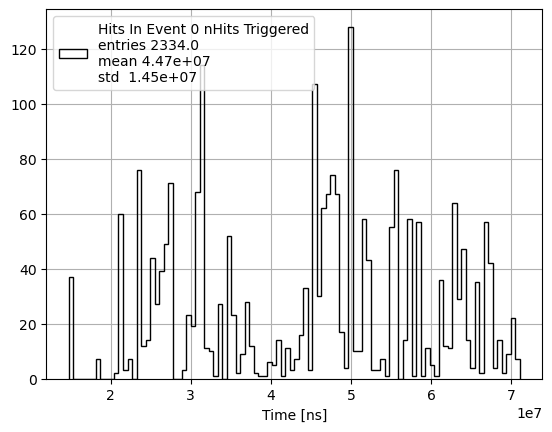

In [144]:
pltext.hist(hit_times[event][triggered_hits_index[event]], 100, ylog=False, xylabels=("Time [ns]"), 
            label=f"Hits In Event {event} nHits Triggered", formate=".2e");